# GRAD CAM

## Import libraries

In [1]:
import tensorflow as tf
keras = tf.keras
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model, Model


import matplotlib.image as mpimg

## Load model

In [2]:
# Cargar tu modelo desde el archivo .h5
model_path = './trained_model.h5'  # Ajusta esta ruta a donde está tu archivo .h5
model = load_model(model_path)

In [3]:
# Nombre de la última capa convolucional del modelo
last_conv_layer_name = 'conv_layer_2_act' 

## Model Summary

In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ res_layer_1 (Rescaling)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_1 (Conv2D)           │ (None, 100, 100, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_1_act (Activation)   │ (None, 100, 100, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_layer_1             │ (None, 50, 50, 8)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2 (Conv2D)           │ (None, 50, 50, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2_act (Activation)   │ (None, 50, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_layer_2             │ (None, 25, 25, 8)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer_1 (Flatten)       │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_layer_2 (Dense)         │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641,196 (2.45 MB)

 Trainable params: 641,194 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Inputs and Outputs

In [5]:
inputs = tf.keras.Input(shape=(100, 100, 3))
outputs = model(inputs)

In [6]:
model_output = model.output

## Check last conv layer

In [7]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [8]:
# Obtener la capa
last_conv_layer = model.get_layer(name=last_conv_layer_name)

print(last_conv_layer)

<Activation name=conv_layer_2_act, built=True>


In [9]:
def make_gradcam_heatmap(img_array, model, last_conv_layer, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(inputs=model.inputs, outputs=[model.output, last_conv_layer.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            print(pred_index)
        class_channel = preds[:, pred_index]
    
        # print(last_conv_layer_output)
        print("class_channel", class_channel)

        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        print("tape", tape)
        grads = tape.gradient(class_channel, last_conv_layer_output)
        print("Grads", grads)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    # print(grads)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    print("pooled_grads", pooled_grads)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [10]:
img_path = 'imagenes_todas/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png'
img_array = get_img_array(img_path, size=(100, 100))


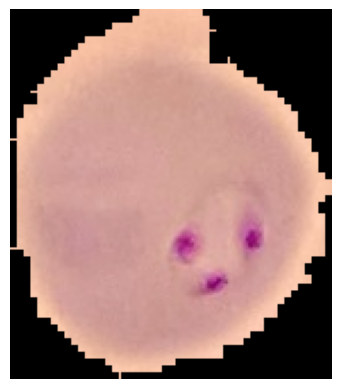

In [11]:
# Cargar y mostrar la imagen
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')  # Para ocultar los ejes
plt.show()

In [12]:
model(img_array)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[9.9999833e-01, 1.6380280e-06]], dtype=float32)>

In [13]:
model.layers

[<Rescaling name=res_layer_1, built=True>,
 <Conv2D name=conv_layer_1, built=True>,
 <Activation name=conv_layer_1_act, built=True>,
 <MaxPooling2D name=max_pooling_layer_1, built=True>,
 <Conv2D name=conv_layer_2, built=True>,
 <Activation name=conv_layer_2_act, built=True>,
 <MaxPooling2D name=max_pooling_layer_2, built=True>,
 <Flatten name=flatten_layer_1, built=True>,
 <Dense name=dense_layer_1, built=True>,
 <Dense name=softmax_layer_2, built=True>]

In [14]:
last_conv_layer_name

'conv_layer_2_act'

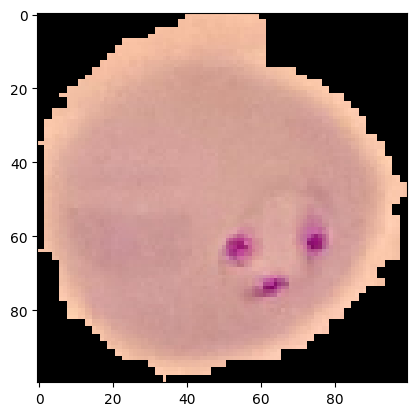

In [15]:
plt.imshow(img_array[0] / 255)

In [16]:
# Generate class activation heatmap
model.layers[-1].activation = None
preds = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


In [17]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer, pred_index=0)

ValueError: The name "input_layer" is used 2 times in the model. All operation names should be unique.

In [ ]:
# Display heatmap
plt.matshow(heatmap)
plt.show()